<a href="https://colab.research.google.com/github/yasuharuokazaki/Learn_MachineLearning/blob/master/%E8%87%AA%E4%B8%BB%E7%A0%94%E7%A9%B6%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **テーマ: MNISTデータを用いた多クラス分類の実装**

## 取り組んだこと  
　0～9の手書きの数字を分類する多クラス分類の実装を、numpyのみを用いて自分で作成することに取り組んだ。  

## 目的
　外部のライブラリを用いず、numpyでモデルを作成することで、モデルの各層がどのようにつながり、機能しているかを理解する。また、正規化項やバッチ処理を自分の手を動かして実装することで、それらの機能や、どのような効果をもたらすかを体験する。 

## 目標
　コーディング演習1の最後に言及されていた、「エポック数20で、精度97％以上」を実現する。
  


## 画像データの前処理

* MNISTのgzipファイルをＤＬ後、機械学習で扱いやすくするため、正規化を行った。

In [2]:
import os
import struct
import sys
import numpy as np


def load_mnist(path,kind="train"):
  labels_path = os.path.join(path,"%s-labels.idx1-ubyte" % kind)
  images_path = os.path.join(path,"%s-images.idx3-ubyte" % kind)

  with open(labels_path,"rb") as bpath:
    magic,n = struct.unpack('>II',bpath.read(8)) # 8バイト分のデータを読み込んで、最初のバイトから（＝ビックエンディアン）4バイトずつ展開し、magic,nに格納する
    labels = np.fromfile(bpath,dtype=np.uint8)   #fromfile=テキストまたはバイナリファイルから配列を作成
  
  with open(images_path,"rb") as imgpath:
    magic,num,rows,cols = struct.unpack(">IIII",imgpath.read(16))

    #ピクセル情報の配列サイズ変更（行数：ラベルのサイズ、列：特徴量の個数）
    images = np.fromfile(imgpath,dtype = np.uint8).reshape(len(labels),784)
    images = ((images/255.)-.5)*2 #ピクセル値の正規化

  return images,labels


* with open(save_dagta,'rb') as f:  
    dataset = pickle.load(f)

### struct
- バイト列を処理するためのモジュール。
-">":ビックエンディアン→バイト列の最初から並べていく指示。
-"<":リトルエンディアン→バイト列の最後から並べていく指示。 

In [3]:
#保存したデータを読み込めるか確認
x_test,y_test = load_mnist('/content/drive/MyDrive/デプロイ課題/',kind='t10k')
x_train,y_train = load_mnist("/content/drive/MyDrive/デプロイ課題/",kind="train")

print("X_train shape:",x_train.shape)
print("X_test shape:",x_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)


## 取得した画像の表示

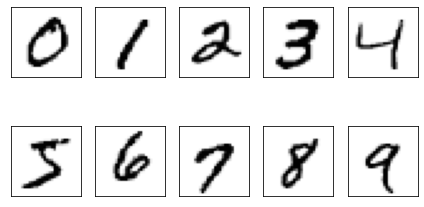

In [4]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(nrows = 2, ncols = 5,sharex = True,sharey=True) #sharex,sharey=x,y軸をすべてのaxで揃えるかどうか
ax = ax.flatten()

for i in range(10):
  img = x_train[y_train == i][0].reshape(28,28)
  ax[i].imshow(img,cmap="Greys")

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 特定の数字のみ表示  
　ラベルが「6」の画像のみを表示。多様な書き方がある。

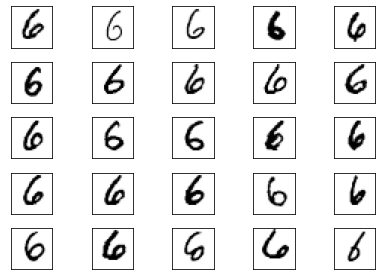

In [7]:
fig,ax = plt.subplots(nrows=5,ncols=5,sharex=True,sharey=True)
ax = ax.flatten()#axを複数作成すると、二次元配列で作成される。それを一次元に変換して、ループ処理で一機に描画できるようにする。

for i in range(25):
  img = x_train[y_train == 6][i].reshape(28,28)
  ax[i].imshow(img,cmap="Greys")

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

　画像データの保存。取り出すときは[リスト内包表記]で順番に取り出せる。

In [ ]:
np.savez_compressed("mnist_scaled.npz",x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test)

In [ ]:
mnist = np.load("mnist_scaled.npz")

In [ ]:
x_train,y_train,x_test,y_test = [ mnist[f] for f in mnist.files ]

In [ ]:
print(x_train.shape[1])

784


# 多層パーセプトロンクラスの作成
### 要件
* 中間層三層
* 活性化関数にはsigmoid関数を利用
* 損失関数には多クラス交差エントロピーを利用

In [17]:
class MLP_Classifier:
  """
  パラメータ
    n_hidden      :隠れユニットの数（int）
    l2            :L2正則化のパラメータ
    epochs        :訓練回数（int）
    eta           :学習率(float)
    shuffle       :訓練データのシャッフル(bool)
    minibatch_size:ミニバッチのサイズ(int)
    seed          :重みやシャッフルの初期化の際のランダムのシード
  ------------------------------------------------------------------

  属性
  　eval_         :訓練エポックごとにコスト、訓練正解率、検証正解率を収集するディクショナリ
  """
  def __init__(self,n_hidden1=30,n_hidden2=50,n_hidden3=30,l2=0.,epochs=10,eta=0.001,shuffle=True,minibatch_size=1,seed=None):
    self.random = np.random.RandomState(seed)
    self.n_hidden1 = n_hidden1
    self.n_hidden2 = n_hidden2
    self.n_hidden3 = n_hidden3
    self.l2 = l2 #L2正則化スイッチ。0なら正則化なし、1なら正則化あり
    self.epochs = epochs
    self.eta =eta
    self.shuffle = shuffle
    self.minibatch_size = minibatch_size

  def _onehot(self,y,n_classes):
    """labelをワンホットエンコーディング
    パラメータ
      ｙ　　　　　：目的変数の値（array,shape[n_examples,]）
  ----------------------------------------------------------
    戻り値
    　onehot       : array,shape[n_examples,n_labels]
    """
    onehot = np.zeros((n_classes,y.shape[0]))
    for idx,val in enumerate(y.astype(int)):
      onehot[val,idx] = 1.
    
    return onehot.T

  def _sigmoid(self,z):
    """シグモイド関数"""
    #そのままだとOverFlowして計算できなかった。
    #→渡す配列の要素が0以上か否かで場合分けをして対応
    if z.all() >= 0:
      s = 1./(1.+np.exp(-np.clip(z,-250,250)))
    else:
      e = np.exp(np.clip(z,-250,250))
      s = e/(e+1)
    return  s
    #1./1. + np.exp(-np.clip(z,-250,250))#np.clip(z,a,b):配列ｚの要素の値をa~bの範囲に制限する

  def _forward(self,X):
    """隠れ層"""
    #[n_classes , n_features] @ [n_features , n_hidden]
    #一層目
    z_h1 = np.dot(X,self.w_h1) +  self.b_h1
    a_h1 = self._sigmoid(z_h1)
    #二層目
    z_h2 = np.dot(a_h1,self.w_h2) +  self.b_h2
    a_h2 = self._sigmoid(z_h2)
    #三層目
    z_h3 = np.dot(a_h2,self.w_h3) +  self.b_h3
    a_h3 = self._sigmoid(z_h3)

    #出力層の重さ×バイアス
    z_out = np.dot(a_h3,self.w_out)+self.b_out
    a_out = self._sigmoid(z_out)

    return z_h1,a_h1,z_h2,a_h2,z_h3,a_h3,z_out,a_out

  def _compute_cost(self,y_enc,output):
    """コスト関数計算
    パラメータ
      y_enc : one-hot化したクラスラベル
      output : 出力層の活性化関数[n_examples,n_output_units]
    ----------------------------------------------------------
    戻り値
     cost : float(正則化されたコスト)※正則化項を付けた場合とつけない場合の差をチェックしたい
    """
    #正則化項
    L2_term = (self.l2 * ( np.sum(self.w_h1 ** 2.) +\
                          np.sum(self.w_h2 ** 2.) + \
                          np.sum(self.w_h3 ** 2.) + \
                          np.sum(self.w_out **2.)))
    #log(sigmoid) = ロジット関数→確率を表すsigmoid関数の出力を、
    #a+bxという線形関係(=sigmoidに渡す前)に直す働きがある。
    term1 = - y_enc * (np.log(output + 1e-5)) #交差エントロピー誤差
    term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
    #残差（標本の実測値-予測値）
    cost = np.sum( term1 - term2 ) + L2_term
    return cost

  def predict(self,X):
    """予測
    パラメータ
      X : 元の特徴量が入力された層[n_examples,n_features]
    -------------------------------------------------------
    戻り値
      y_pred : 予測されたクラスラベル[n_examples]
    """
    z_h1,a_h1,z_h2,a_h2,z_h3,a_h3,z_out,a_out = self._forward(X)
    y_pred = np.argmax(z_out,axis = 1) #一番確率が高いクラスのインデックスを予測結果として返す

    return y_pred
  def fit(self,X_train,y_train,X_valid,y_valid):
    """重みの学習
    パラメータ
      X_train : 元の特徴量が入力された配列[n_examples,n_features]
      y_train : 目的変数[n_exampes]
      X_valid : 訓練時の検証に使うサンプル[n_examples,n_featuers]
      y_valid : 訓練時の検証に使うサンプルラベル[n_examples]
  ------------------------------------------------------------------------
    戻り値
    self
    """
    n_output = np.unique(y_train).shape[0] #y_train=[5,3,2,...,]→[0,1,2,3,4,5,6,7,8,9]
    n_features = X_train.shape[1]          #784

    #重み初期化
    #隠れ層(3層)
    self.b_h1 = np.zeros(self.n_hidden1)
    self.w_h1 = self.random.normal(loc=0.0,scale=0.1,size=(n_features,self.n_hidden1))
    self.b_h2 = np.zeros(self.n_hidden2)
    self.w_h2 = self.random.normal(loc=0.0,scale=0.1,size=(self.n_hidden1,self.n_hidden2))
    self.b_h3 = np.zeros(self.n_hidden3)
    self.w_h3 = self.random.normal(loc=0.0,scale=0.1,size=(self.n_hidden2,self.n_hidden3))
    #出力層
    self.b_out = np.zeros(n_output)
    self.w_out = self.random.normal(loc=0.0,scale=0.1,size=(self.n_hidden3,n_output))

    #書式設定
    epoch_strlen = len(str(self.epochs))
    self.eval_ = {"cost":[],"train_acc":[],"valid_acc":[]}
    y_train_enc = self._onehot(y_train,n_output)

    #訓練
    for i in range(self.epochs):
      #mini_batch 反復
      indices = np.arange(X_train.shape[0]) #X_tranのサイズ分の整数作成
      
      if self.shuffle:
        self.random.shuffle(indices) #indicesの順番シャッフル
      
      #バッチサイズでループ
      for start_idx in range(0,indices.shape[0] - self.minibatch_size+1,self.minibatch_size):
        batch_idx = indices[start_idx:start_idx + self.minibatch_size]

        #forward
        z_h1,a_h1,z_h2,a_h2,z_h3,a_h3,z_out,a_out = self._forward(X_train[batch_idx])

        #backward
        #出力→sigmoid
        delta_out = a_out - y_train_enc[batch_idx] #sigmoidが吐き出した確率と、正解ラベル（onehot）の差
        sigmoid_derivative_h3 = a_h3 * (1. - a_h3)
        delta_h3 = np.dot(delta_out,self.w_out.T) * sigmoid_derivative_h3
      
        grad_w_out = np.dot(a_h3.T,delta_out)
        grad_b_out = np.sum(delta_out,axis =0)
        grad_w_h3 = np.dot(a_h2.T,delta_h3)
        grad_b_h3 = np.sum(delta_h3,axis = 0)

        sigmoid_derivative_h2 = a_h2 * (1. - a_h2)
        delta_h2 = np.dot(delta_h3,self.w_h3.T)*sigmoid_derivative_h2
        
        grad_w_h2 = np.dot(a_h1.T,delta_h2)
        grad_b_h2 = np.sum( delta_h2,axis = 0 )

        sigmoid_derivative_h1 = a_h1 * (1. - a_h1)
        delta_h1 = np.dot(delta_h2,self.w_h2.T)*sigmoid_derivative_h1

        grad_w_h1 = np.dot(X_train[batch_idx].T,delta_h1)
        grad_b_h1 = np.sum(delta_h1,axis=0)

        #正則化＆重み更新
   
        delta_w_h1 = (grad_w_h1 + self.l2*self.w_h1)
        delta_b_h1 = grad_b_h1 #バイアスは正則化しない！
        delta_w_h2 = (grad_w_h2 + self.l2*self.w_h2)
        delta_b_h2 = grad_b_h2
        delta_w_h3 = (grad_w_h3 + self.l2*self.w_h3)
        delta_b_h3 = grad_b_h3
        self.w_h1 -= self.eta * delta_w_h1
        self.b_h1 -= self.eta * delta_b_h1
        self.w_h2 -= self.eta * delta_w_h2
        self.b_h2 -= self.eta * delta_b_h2
        self.w_h3 -= self.eta * delta_w_h3
        self.b_h3 -= self.eta * delta_b_h3

        delta_w_out = (grad_w_out +self.l2*self.w_out)
        delta_b_out = grad_b_out
        self.w_out -= self.eta * delta_w_out
        self.b_out -= self.eta * delta_b_out

    ##########
      #評価
    ##########
      z_h1,a_h1,z_h2,a_h2,z_h3,a_h3,z_out,a_out = self._forward(X_train)
      cost = self._compute_cost(y_enc = y_train_enc,output = a_out)

      y_train_pred = self.predict(X_train)
      y_valid_pred = self.predict(X_valid)
      train_acc = ((np.sum(y_train==y_train_pred)).astype(np.float)/X_train.shape[0])

      valid_acc = ((np.sum(y_valid==y_valid_pred)).astype(np.float)/X_valid.shape[0])

      sys.stderr.write('\r%0*d/%d | Cost: %.2f | Train/Valid Acc.: %.2f%%/%.2f%%'%(epoch_strlen,i+1,self.epochs,cost,train_acc*100,valid_acc*100) )
      sys.stderr.flush()
      self.eval_["cost"].append(cost)
      self.eval_["train_acc"].append(train_acc)
      self.eval_["valid_acc"].append(valid_acc)

    return self




# 正則化項を利用しない、かつオンライン学習の場合

*   トレーニング/バリデーションチェック　：　89.56％/91.16％
*   学習時間　：　11分
*   テストデータに対する精度：89.44％





In [30]:
nn = MLP_Classifier(n_hidden1=30,n_hidden2=50,n_hidden3=30,l2=0.00,epochs=20,eta=0.0005,minibatch_size = 1,shuffle=True,seed=1)

In [31]:
nn.fit(X_train=x_train[:55000],y_train=y_train[:55000],X_valid=x_train[55000:],y_valid=y_train[55000:])

20/20 | Cost: 41806.49 | Train/Valid Acc.: 89.56%/91.16%

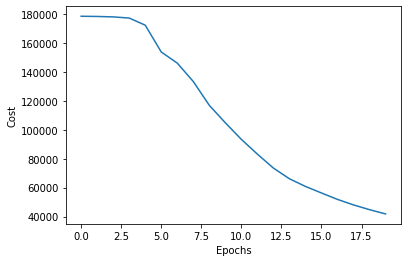

In [32]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs),nn.eval_["cost"])
plt.ylabel("Cost")
plt.xlabel("Epochs")
plt.show()

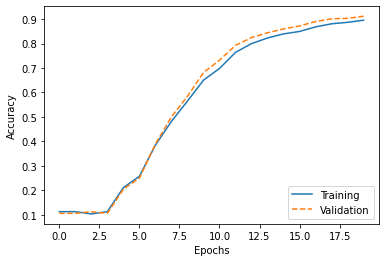

In [33]:
plt.plot(range(nn.epochs),nn.eval_["train_acc"],label="Training")
plt.plot(range(nn.epochs),nn.eval_["valid_acc"],label="Validation",linestyle="--")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.show()

In [34]:
y_test_pred = nn.predict(x_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float)/x_test.shape[0])
print("テスト精度:,%.2f%%"%(acc*100))

テスト精度:,89.44%


## 検証
　テストデータに対する精度が約89％。
　97％に至らない理由としては次のことが考えられる。


*   
　学習時において、エポック数が5を超えたあたりから、バリデーションの精度がトレーニングの精度を上回っている→バリデーションを過学習している可能性あり。
*   オンラインのため、時間がかかっている。局所解には陥っていなさそう。



# 正則化項を導入した場合


*   リスト項目

*   リスト項目
*   リスト項目


*   リスト項目



In [35]:
nn2 =  MLP_Classifier(n_hidden1=30,n_hidden2=50,n_hidden3=30,l2=0.01,epochs=20,eta=0.0005,minibatch_size = 1,shuffle=True,seed=1)

In [36]:
nn2.fit(X_train=x_train[:55000],y_train=y_train[:55000],X_valid=x_train[55000:],y_valid=y_train[55000:])

20/20 | Cost: 178783.71 | Train/Valid Acc.: 10.37%/11.26%

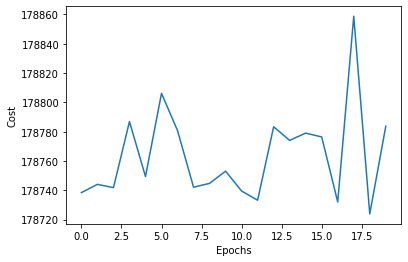

In [40]:
plt.plot(range(nn2.epochs),nn2.eval_["cost"])
plt.ylabel("Cost")
plt.xlabel("Epochs")
plt.show()

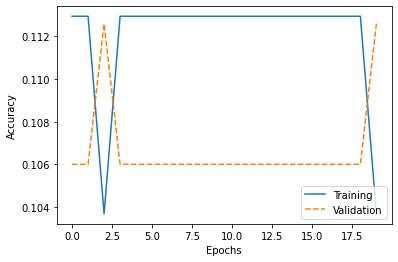

In [39]:
plt.plot(range(nn2.epochs),nn2.eval_["train_acc"],label="Training")
plt.plot(range(nn2.epochs),nn2.eval_["valid_acc"],label="Validation",linestyle="--")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.show()